# Import Librariies

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image


import os
import random


import warnings
warnings.filterwarnings("ignore")

2025-07-09 01:05:59.389456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752023159.598868      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752023159.655636      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get Data

In [3]:
image_folder_path = '/kaggle/input/teeth-dataset/Teeth_Dataset'
train_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
test_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'
validation_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'

In [4]:
folders = list(os.listdir(image_folder_path))
print(folders)

['Validation', 'Training', 'Testing']


In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path)
test_data = tf.keras.utils.image_dataset_from_directory(test_path)
validation_data = tf.keras.utils.image_dataset_from_directory(validation_path)

Found 3087 files belonging to 7 classes.


I0000 00:00:1752023173.610542      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752023173.611222      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [6]:
diseases = list(os.listdir(os.path.join(image_folder_path,'Testing')))
print(diseases)

['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']


# Prepare Data

In [7]:
def plot_1_per_disease_in_folder(folder):
    fig, axes = plt.subplots(1, len(diseases), figsize=(10, 10))

    for ax, disease in zip(axes, diseases):
        diseases_dir = os.path.join(image_folder_path, folder, disease)
        valid_extensions = ('.jpeg', '.jpg', '.bmp', '.png')
        diseases_images = list(filter(lambda x: x.endswith(valid_extensions), os.listdir(diseases_dir)))

        if diseases_images:
            img_path = os.path.join(diseases_dir, random.choice(diseases_images))
            image = plt.imread(img_path)
            ax.imshow(image)
            ax.set_title(disease)
            ax.axis('off')
        else:
            ax.set_title(f'No images for {illness}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    


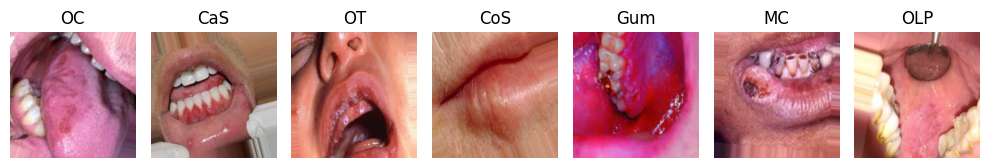

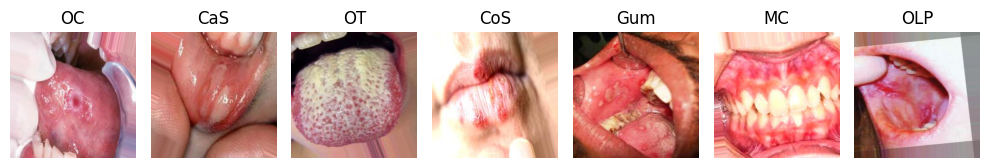

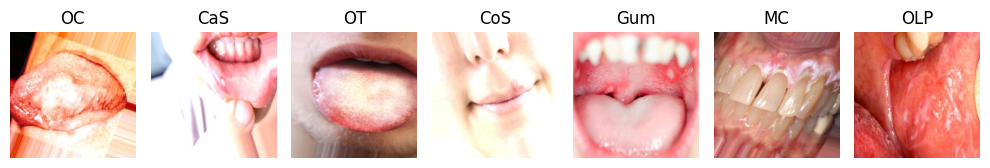

In [8]:

plot_1_per_disease_in_folder(folders[0] )

plot_1_per_disease_in_folder(folders[1] )

plot_1_per_disease_in_folder(folders[2] )


In [9]:

def load_train_data_and_preprocess_it(train_data, target_size, batch_size):
    train_gen = ImageDataGenerator(
        rescale =  1/255.0,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
    )

    train = train_gen.flow_from_directory(
        train_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    return train

def load_validation_data_and_preprocess_it(validation_data, target_size, batch_size):
    validation_gen = ImageDataGenerator(
        rescale =  1/255.0,
    )

    validation = validation_gen.flow_from_directory(
        validation_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )

    return validation


In [10]:
train = load_train_data_and_preprocess_it(
                train_path,
                target_size=(150, 150),
                batch_size=32
                )

validation = load_validation_data_and_preprocess_it(
                validation_path,
                target_size=(150, 150),
                batch_size=32
                )

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [11]:
imgs, labels = next(train)
print(imgs.shape)
print(labels.shape)

(32, 150, 150, 3)
(32, 7)


In [12]:
print(train.class_indices)
print(validation.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [13]:

bad_images = []

base_path = '/kaggle/input/teethdataset/Teeth_Dataset/Training'

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Will raise an exception if the image is corrupted
            except:
                bad_images.append(os.path.join(root, file))

print("Bad images:", bad_images)


Bad images: []


# Modeling

## Model 1

In [14]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [15]:


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [16]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,037,255 (72.62 MB)

 Trainable params: 19,037,255 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

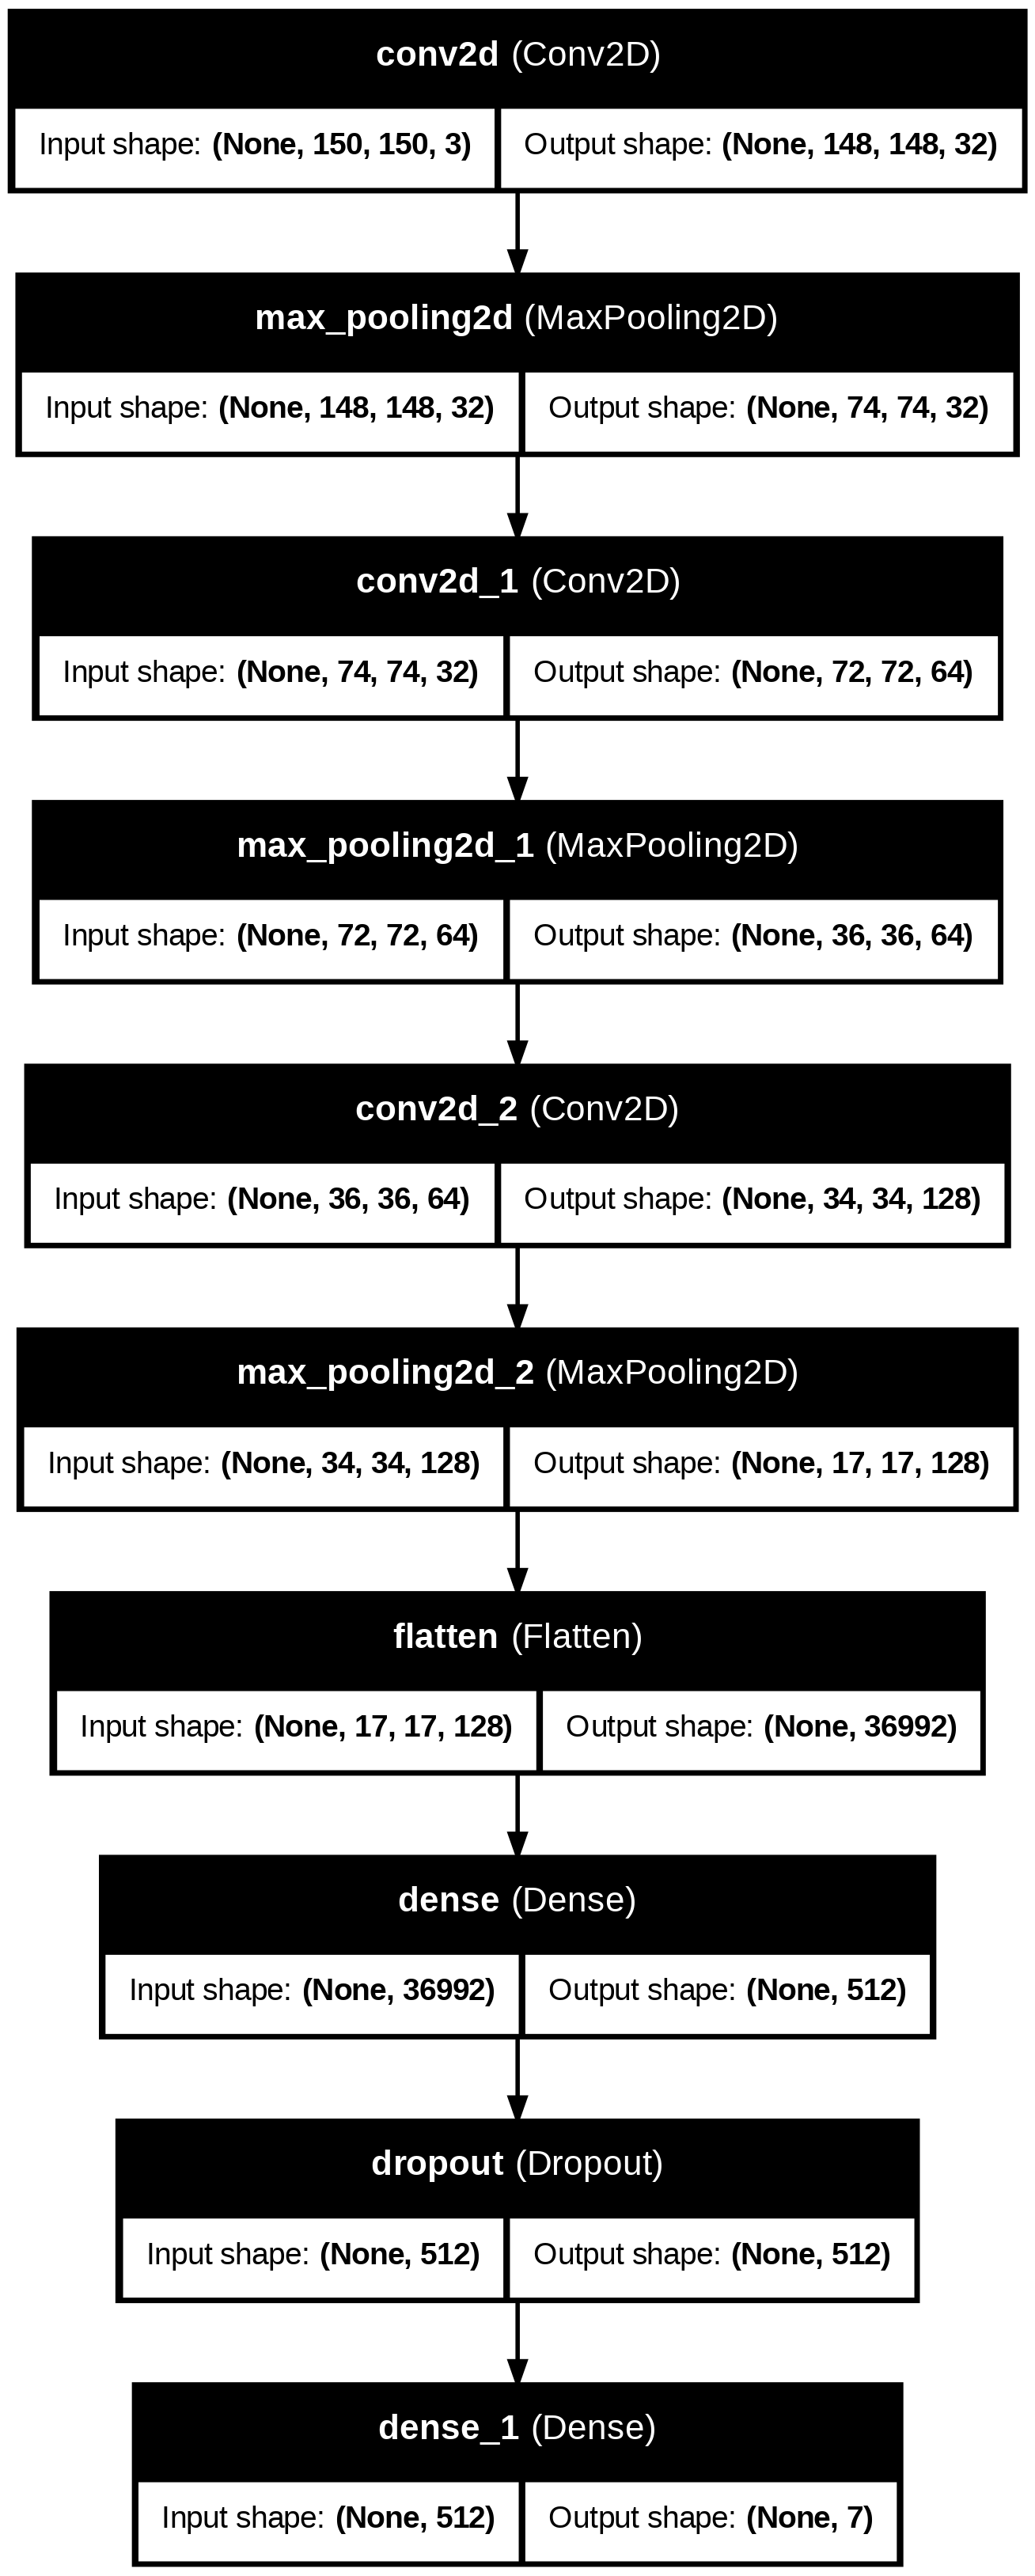

In [20]:
plot_model(
    model,
    to_file='model1.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [21]:

history = model.fit(
    train,
    epochs = 100,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.7409 - loss: 0.7123 - val_accuracy: 0.8706 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.7489 - loss: 0.6933 - val_accuracy: 0.8444 - val_loss: 0.4965 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.7378 - loss: 0.7154 - val_accuracy: 0.8755 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.7590 - loss: 0.6919 - val_accuracy: 0.8755 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.7617 - loss: 0.6620 - val_accuracy: 0.8891 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.7740 - loss: 0.6357 - val_accuracy: 0.9037 - val_loss: 0.3221 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.7670 - l

<Axes: >

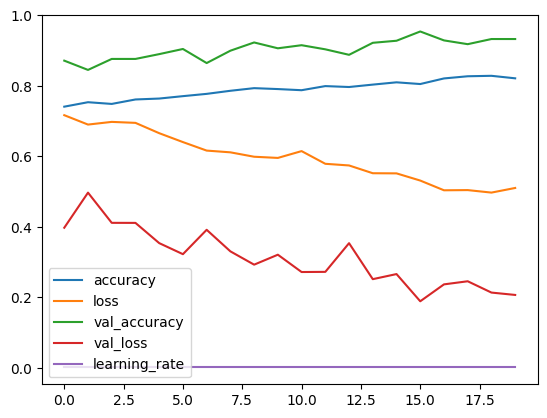

In [22]:

model_history = history.history
loss_acc_df = pd.DataFrame(model_history)
loss_acc_df.plot()

In [23]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = model.history.epoch

def plot_acc(acc, val_acc, epochs):
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  plt.show()


def plot_loss(loss, val_loss, epochs):
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()



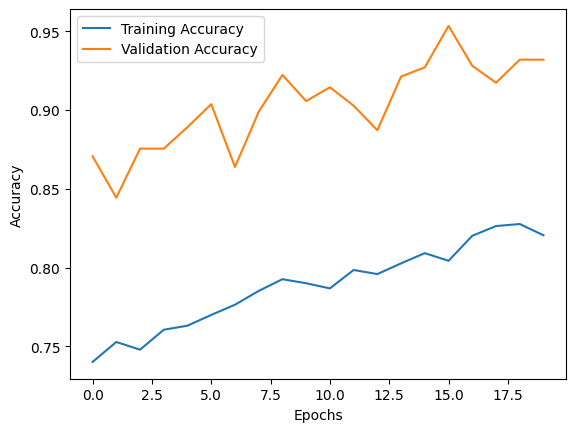

In [24]:
plot_acc(acc, val_acc, epochs)

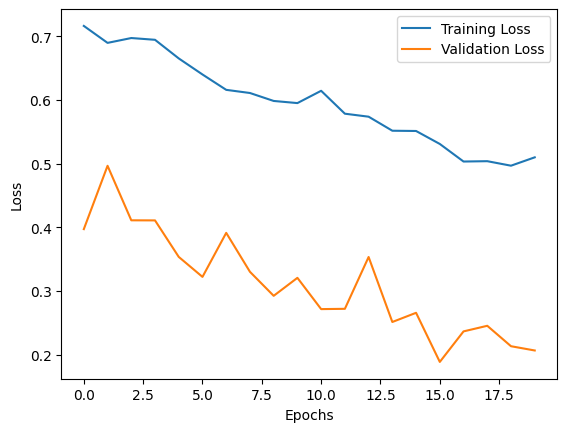

In [25]:
plot_loss(loss, val_loss, epochs)

In [26]:
test = load_validation_data_and_preprocess_it(
                test_path,
                target_size=(150, 150),
                batch_size=32
                )

Found 1028 images belonging to 7 classes.


In [27]:
test_loss, test_accuracy = model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9473 - loss: 0.1548


In [28]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.17262716591358185
Test Accuracy: 0.951361894607544


In [29]:

predictions = model.predict(test)


y_pred = np.argmax(predictions, axis=1)
y_true = test.classes


class_labels = list(test.class_indices.keys())


report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
              precision    recall  f1-score   support

         CaS       0.96      0.93      0.95       160
         CoS       0.99      0.99      0.99       149
         Gum       0.97      0.95      0.96       120
          MC       0.98      0.91      0.94       180
          OC       0.91      0.95      0.93       108
         OLP       0.91      0.97      0.94       180
          OT       0.94      0.96      0.95       131

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



<Figure size 800x600 with 0 Axes>

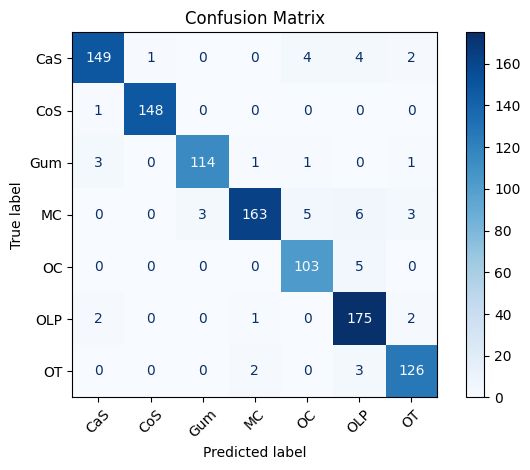

In [30]:



cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [31]:
model.save('model1.keras')


## Model 2

In [33]:



    model2 = Sequential()
    
    # Convolutional layers
    model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))
    
    model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))
    
    model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model2.add(BatchNormalization())   
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.3))
    
    model2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.3))
    
    # Flatten and Dense layers
    model2.add(Flatten())
    
    model2.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))
       
    model2.add(Dense(units=7, activation='softmax')) 








    model2.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

In [34]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,604,679 (13.75 MB)

 Trainable params: 3,603,207 (13.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

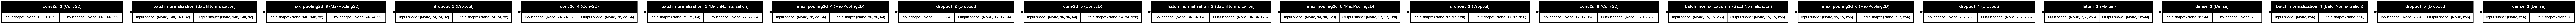

In [38]:
plot_model(
    model2,
    to_file='model2.png',    
    show_shapes=True,    
    show_layer_names=True,
    rankdir="LR"
)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [37]:
history2 = model2.fit(
    train,
    epochs=20,  
    validation_data=validation,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 273ms/step - accuracy: 0.2276 - loss: 3.1689 - val_accuracy: 0.1644 - val_loss: 5.3107 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.3086 - loss: 2.7837 - val_accuracy: 0.1469 - val_loss: 7.7357 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.3653 - loss: 2.4881 - val_accuracy: 0.1508 - val_loss: 6.7455 - learning_rate: 0.0010
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.4191 - loss: 2.3035 - val_accuracy: 0.2519 - val_loss: 4.7230 - learning_rate: 0.0010
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.4387 - loss: 2.2094 - val_accuracy: 0.2899 - val_loss: 3.4891 - learning_rate: 0.0010
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.4589 - loss: 2.1093 - val_accuracy: 0.3123 - val_loss: 3.5728 - learning_rate: 0.0010
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.4984 - loss: 1.

In [39]:
history2 = model2.fit(
    train,
    epochs=50,  
    validation_data=validation,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.7414 - loss: 1.2156 - val_accuracy: 0.8142 - val_loss: 1.0649 - learning_rate: 2.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.7355 - loss: 1.1911 - val_accuracy: 0.7947 - val_loss: 1.0938 - learning_rate: 2.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.7442 - loss: 1.1860 - val_accuracy: 0.8531 - val_loss: 0.9233 - learning_rate: 2.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.7501 - loss: 1.1197 - val_accuracy: 0.8531 - val_loss: 0.9090 - learning_rate: 2.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.7385 - loss: 1.1390 - val_accuracy: 0.7870 - val_loss: 1.0379 - learning_rate: 2.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.7769 - loss: 1.0695 - val_accuracy: 0.8716 - val_loss: 0.8323 - learning_rate: 2.0000e-04
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - acc

In [49]:
history2 = model2.fit(
    train,
    epochs=40,  
    validation_data=validation,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.9094 - loss: 0.5964 - val_accuracy: 0.9523 - val_loss: 0.4817 - learning_rate: 4.0000e-05
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.8963 - loss: 0.6037 - val_accuracy: 0.9621 - val_loss: 0.4354 - learning_rate: 4.0000e-05
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.9018 - loss: 0.5964 - val_accuracy: 0.9660 - val_loss: 0.4302 - learning_rate: 4.0000e-05
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.9100 - loss: 0.5611 - val_accuracy: 0.9270 - val_loss: 0.5323 - learning_rate: 4.0000e-05
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.9091 - loss: 0.5835 - val_accuracy: 0.9572 - val_loss: 0.4528 - learning_rate: 4.0000e-05
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.9092 - loss: 0.5722 - val_accuracy: 0.9484 - val_loss: 0.4707 - learning_rate: 4.0000e-05
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - acc

<Axes: >

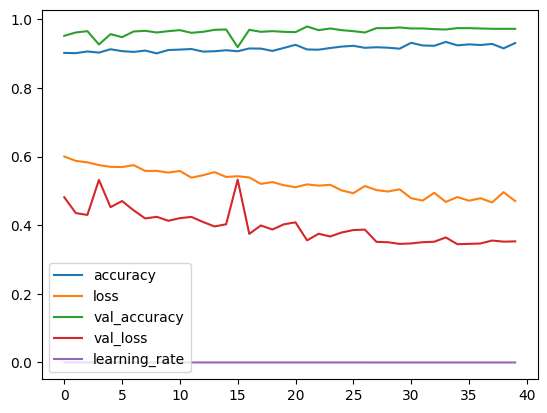

In [50]:
model_history2 = history2.history
loss_acc_df2 = pd.DataFrame(model_history2)
loss_acc_df2.plot()

In [51]:
acc2 = model_history2['accuracy']
val_acc2 = model_history2['val_accuracy']
loss2 = model_history2['loss']
val_loss2 = model_history2['val_loss']

epochs2 = model2.history.epoch

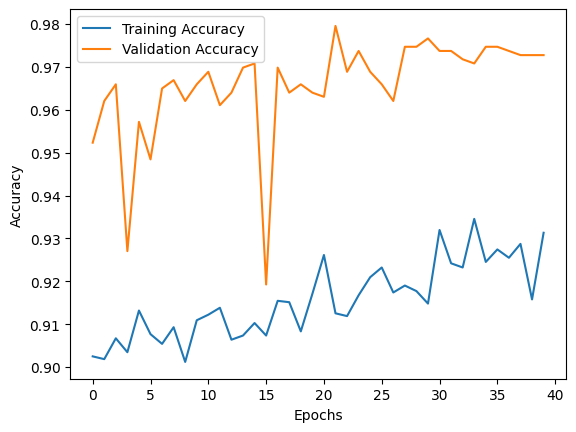

In [52]:
plot_acc(acc2, val_acc2, epochs2)

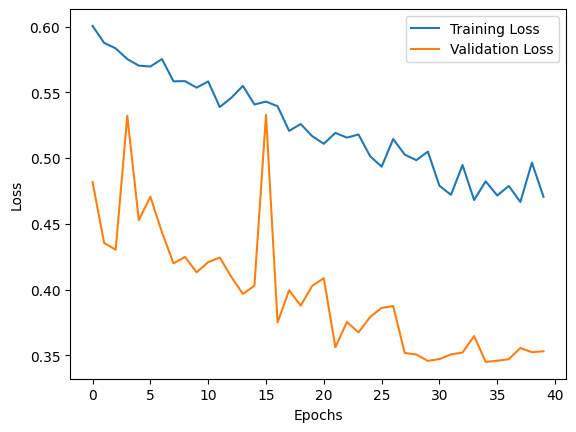

In [53]:
plot_loss(loss2, val_loss2, epochs2)

In [54]:
test_loss2, test_accuracy2 = model2.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9873 - loss: 0.3034


In [55]:
print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

Test Loss: 0.33055728673934937
Test Accuracy: 0.9747081995010376


In [56]:
predictions2 = model2.predict(test)


y_pred2 = np.argmax(predictions2, axis=1)
y_true2 = test.classes


class_labels2 = list(test.class_indices.keys())


report2 = classification_report(y_true2, y_pred2, target_names=class_labels2)
print(report2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
              precision    recall  f1-score   support

         CaS       0.95      1.00      0.98       160
         CoS       0.98      1.00      0.99       149
         Gum       0.99      0.98      0.99       120
          MC       0.98      0.96      0.97       180
          OC       0.97      0.94      0.95       108
         OLP       0.97      0.96      0.96       180
          OT       0.99      0.99      0.99       131

    accuracy                           0.97      1028
   macro avg       0.98      0.97      0.98      1028
weighted avg       0.97      0.97      0.97      1028



<Figure size 800x600 with 0 Axes>

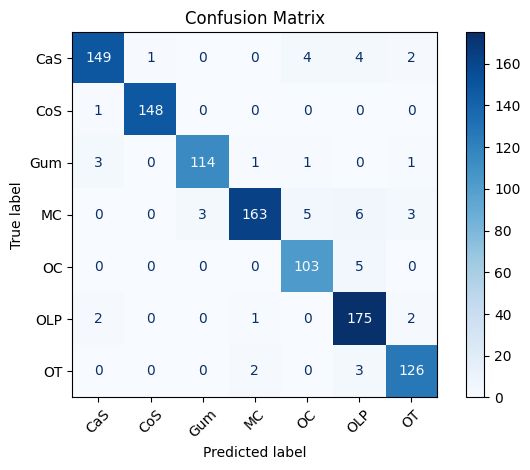

In [57]:
cm2 = confusion_matrix(y_true2, y_pred2)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels2)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [58]:
model.save('model2.keras')

# The best Model is `Model 2`

## Save Details About the best model

In [59]:

#Save the training history
with open('Teeth_Disease_History.pkl', 'wb') as f:
    pickle.dump(history2.history, f)


In [62]:

# Save the preprocessing configuration
with open('preprocessing_config.pkl', 'wb') as f:
    pickle.dump({
        'rescale' :  1/255.0,
        'rotation_range' : 20,
        'width_shift_range' : 0.2,
        'height_shift_range' : 0.2,
        'shear_range' : 0.2,
        'zoom_range' : 0.2,
        'horizontal_flip' : True,
        'fill_mode' : 'nearest',
    }, f)


In [63]:
# Save the augmented data pipeline configuration
with open('augmented_data_pipeline_config.pkl', 'wb') as f:
    pickle.dump({
        'image_size': (150, 150),
        'batch_size': 32
    }, f)